In [345]:
from include.Wine_data import *
from include.Fire_data import *
from sklearn.model_selection import StratifiedKFold, learning_curve
from time import perf_counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [349]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(max(0, historydf.values.min()), max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    vloss = history.history['val_loss'][-1]
    vacc = history.history['val_accuracy'][-1]
    plt.title('Loss: %.3f, Acc: %.3f, vLoss: %.3f, vAcc: %.3f' % (loss, acc, vloss, vacc))
    
def train_validate_fold(model, _X_train, _y_train, _X_val, _y_val, epochs=200):
    model.get_weights()
    print("training for ", epochs, "epochs")
    model.fit(_X_train, _y_train, epochs=epochs, verbose = 0)
    scores = model.evaluate(_X_val, _y_val, verbose=0)
    return scores

In [358]:
def nn(X_train, y_train,  X_test, y_test, layers = [16, 8], lr=0.001, batch_size=10, epochs = 100):
    _model = Sequential()
    for i,l in enumerate(layers):
        if i == 0 : 
            _model.add(Dense(l, activation='relu', input_shape=(X_train.shape[1],)))
        else:
            _model.add(Dense(l, activation='relu'))
    es = EarlyStopping(monitor='loss', patience=5)
    t = perf_counter()
    result = {'layers':layers, 'lr':lr, 'batch_size':batch_size}
    _model.add(Dense(1, activation='sigmoid'))
    _model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    result['history'] = _model.fit(X_train, y_train, epochs=epochs, verbose=0,  batch_size=batch_size, validation_split=0.2 , callbacks = [es])
    result['time'] = perf_counter() - t
    result['it'] = len(result['history'].history['loss'])
    result['val_accuracy'] = result['history'].history['val_accuracy'][-1]
    result['model'] = _model
    return result


def nn_search(X_train, y_train,  X_test, y_test, layers=[[16,8]], lrs=[0.001], batch_sizes=[10], epochs=1000):
    results = []
    for l in layers:
        for lr in lrs:
            for batch_size in batch_sizes:
                results.append(
                    nn(
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test,
                        layers = l,
                        lr = lr,
                        batch_size = batch_size,
                        epochs = epochs
                    )
                )
    return results


def nn_experiment(obj = wine, exp = None):
    layers =[[2,2],[4,4],[8,4],[16,8],[32,16],[64,32],[64,64]]
    _X_train = obj.X_train
    _X_test = obj.X_test
    if exp is not None:
        _X_train = obj.models[exp]['X_train']
        _X_test = obj.models[exp]['X_test']
        
    results = nn_search(
        X_train = _X_train,
        y_train = obj.y_train,
        X_test = _X_test,
        y_test = obj.y_test,
        layers = layers,
        batch_sizes=[None],
        epochs = 500
    )
    for r in results:
        print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(_X_test, obj.y_test))
    return results

In [353]:
wine = Wine.load_pickle()
#a summary
print("test data pos percentage", len(wine.y_test[wine.y_test['good']==1]) / len(wine.y_test))


loading pickle:  ../data/pickles/Wine.pickle
test data pos percentage 0.55625


In [351]:
layers =[[2,2],[4,4],[8,4],[16,8],[32,16],[64,32],[64,64]]
wine_results_raw = nn_search(
    X_train = wine.X_train,
    y_train = wine.y_train,
    X_test = wine.X_test,
    y_test = wine.y_test,
    layers = layers,
    batch_sizes=[None],
    epochs = 500
)
for r in wine_results_raw:
    print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(wine.X_test, wine.y_test))


51/51 [==============================] - 0s 2ms/step - loss: 0.3914 - accuracy: 0.8222
result:  0.8164102435112 [2, 2] it: 136 time 35.644908344955184 [0.39144784212112427, 0.8221538662910461]
51/51 [==============================] - 0s 2ms/step - loss: 0.3766 - accuracy: 0.8234
result:  0.802051305770874 [4, 4] it: 161 time 42.061493991990574 [0.3765564560890198, 0.8233846426010132]
51/51 [==============================] - 0s 2ms/step - loss: 0.3746 - accuracy: 0.8240
result:  0.8133333325386047 [8, 4] it: 141 time 40.075359803042375 [0.37459397315979004, 0.8240000009536743]
51/51 [==============================] - 0s 2ms/step - loss: 0.3643 - accuracy: 0.8295
result:  0.8287179470062256 [16, 8] it: 78 time 24.17899463302456 [0.36429840326309204, 0.8295384645462036]
51/51 [==============================] - 0s 2ms/step - loss: 0.3641 - accuracy: 0.8289
result:  0.818461537361145 [32, 16] it: 88 time 24.37546430504881 [0.36405348777770996, 0.8289231061935425]
51/51 [====================

In [ ]:
results_pca = nn_experiment(obj=wine, exp = 'pca')

In [ ]:
results_ica = nn_experiment(obj=wine, exp = 'ica')

In [ ]:
results_pca = nn_experiment(obj=wine, exp = 'pca')

<Figure size 576x432 with 0 Axes>

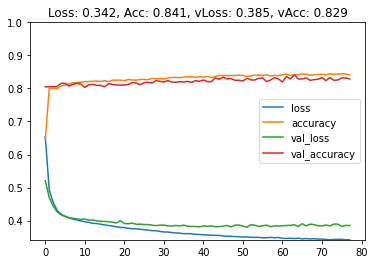

In [356]:
plot_loss_accuracy(wine_results_raw[3]['history'])
plt.show()

loading ../data/algerian_fire/data_combined.csv
<class 'include.Fire_data.Fire'>
Scale type:  StandardScaler()
doing scaling
scaling ['Rain', 'Ws', 'year', 'FFMC', 'DMC', 'day', 'Temperature', 'ISI', 'DC', 'BUI', 'FWI', 'RH']
all data positive :  138 neg:  106
split: Train:  170 170 Test:  74 74
train positive :  91 neg:  79


<Figure size 576x432 with 0 Axes>

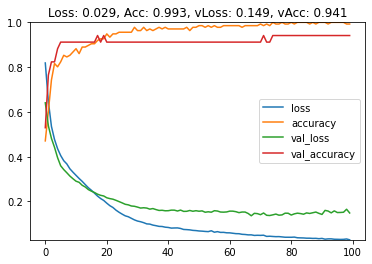

In [122]:
fire = Fire(verbose=True, oversample=False, scale=True, test_size=0.3)
fX_train, fy_train, fX_test, fy_test = fire.X_train, fire.y_train, fire.X_test, fire.y_test
fmodel = Sequential()
fmodel.add(Dense(16, activation='relu', input_shape=(fX_train.shape[1],)))
fmodel.add(Dense(8, activation='relu'))
fmodel.add(Dense(1, activation='sigmoid'))
fmodel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
fhistory = fmodel.fit(fX_train, fy_train, epochs=100, verbose=0,  batch_size=10, validation_split=0.2 )
plot_loss_accuracy(fhistory)
plt.show()

In [123]:
print(fmodel.evaluate(fX_test, fy_test))
fire.pickle()

3/3 [==============================] - 0s 2ms/step - loss: 0.1018 - accuracy: 0.9865
[0.10176612436771393, 0.9864864945411682]


In [224]:
fire_import = Fire.load_pickle()
wine_import = Wine.load_pickle()

loading pickle:  ../data/pickles/Fire.pickle
loading pickle:  ../data/pickles/Wine.pickle


In [255]:
# print(len(wine_import.y_test['1']))
len(wine_import.y_test[wine_import.y_test['good']==1]) / len(wine_import.y_test)

0.19435897435897437

In [199]:

results = nn(
    X_train = fire_import.models['pca']['X_train'],
    y_train = fire_import.y_train,
    X_test = fire_import.models['pca']['X_test'],
    y_test = fire_import.y_test,
    layers = [4,8]
)
print(results)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [269]:
layers =[[2,2],[4,4],[8,4],[16,8],[32,16],[64,32]]
wine_results_raw = nn_search(
    X_train = wine_import.X_train,
    y_train = wine_import.y_train,
    X_test = wine_import.X_test,
    y_test = wine_import.y_test,
    layers = [[20,20]],
    batch_sizes=[None, 5, 10,20,],
    epochs = 1000
)
for r in wine_results_raw:
    print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(wine_import.X_test, wine_import.y_test))


61/61 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8344
result:  0.8219780325889587 [20, 20] it: 59 time 14.264542519929819 [0.36820223927497864, 0.8343589901924133]
61/61 [==============================] - 0s 2ms/step - loss: 0.3586 - accuracy: 0.8292
result:  0.8274725079536438 [20, 20] it: 60 time 85.16344186197966 [0.35862019658088684, 0.829230785369873]
61/61 [==============================] - 0s 2ms/step - loss: 0.3678 - accuracy: 0.8313
result:  0.8175824284553528 [20, 20] it: 48 time 36.623733694897965 [0.3678210377693176, 0.8312820792198181]
61/61 [==============================] - 0s 2ms/step - loss: 0.3727 - accuracy: 0.8210
result:  0.8307692408561707 [20, 20] it: 110 time 42.675378537969664 [0.37274983525276184, 0.8210256695747375]


<Figure size 576x432 with 0 Axes>

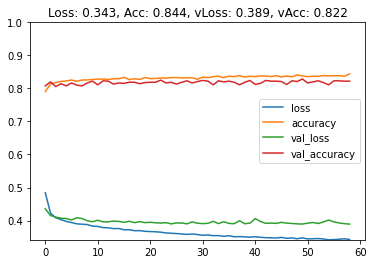

In [271]:
plot_loss_accuracy(wine_results_raw[0]['history'])
plt.show()

In [242]:

for r in wine_results_raw:
    print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(wine_import.X_test, wine_import.y_test))
# plot_loss_accuracy(results_raw[0]['history'])
# plt.show()

61/61 [==============================] - 0s 2ms/step - loss: 0.3928 - accuracy: 0.8118
result:  0.805494487285614 [2, 2] it: 63 time 49.20691419497598 [0.39275243878364563, 0.8117948770523071]
61/61 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 0.8159
result:  0.8065934181213379 [4, 4] it: 60 time 45.725999137968756 [0.3773980438709259, 0.8158974647521973]
61/61 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.8118
result:  0.805494487285614 [8, 4] it: 80 time 58.06018116406631 [0.38145315647125244, 0.8117948770523071]
61/61 [==============================] - 0s 2ms/step - loss: 0.3727 - accuracy: 0.8164
result:  0.8175824284553528 [16, 8] it: 56 time 39.867546699009836 [0.3726537525653839, 0.8164102435112]
61/61 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8272
result:  0.8241758346557617 [32, 16] it: 55 time 39.285895033041015 [0.36926698684692383, 0.827179491519928]
61/61 [=========================

<Figure size 576x432 with 0 Axes>

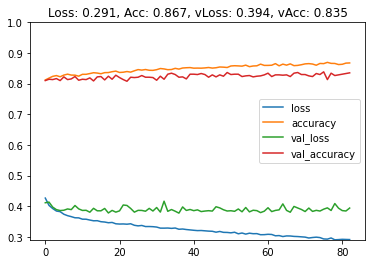

In [244]:
plot_loss_accuracy(wine_results_raw[-1]['history'])
plt.show()

In [259]:
layers = [[8,4],[16,8],[32,16],[64,32]]
wine_results_pca = nn_search(
    X_train = wine_import.models['pca']['X_train'],
    y_train = wine_import.y_train,
    X_test = wine_import.models['pca']['X_test'],
    y_test = wine_import.y_test,
    layers = layers,
    epochs = 1000
)

In [260]:

for r in wine_results_pca:
    print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(wine_import.models['pca']['X_test'], wine_import.y_test))

61/61 [==============================] - 0s 2ms/step - loss: 0.4241 - accuracy: 0.8113
result:  0.807692289352417 [8, 4] it: 52 time 37.76504843891598 [0.42413970828056335, 0.8112820386886597]
61/61 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.8087
result:  0.797802209854126 [16, 8] it: 27 time 19.3244669000851 [0.4210595190525055, 0.8087179660797119]
61/61 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.8092
result:  0.803296685218811 [32, 16] it: 24 time 17.25283857807517 [0.4202175736427307, 0.8092307448387146]
61/61 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.8123
result:  0.8010988831520081 [64, 32] it: 23 time 16.554140724940225 [0.41901901364326477, 0.8123077154159546]


<Figure size 576x432 with 0 Axes>

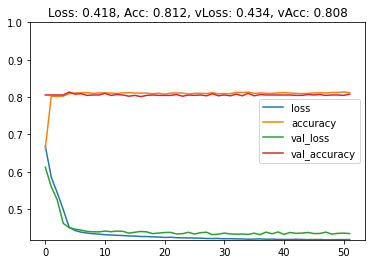

In [262]:
plot_loss_accuracy(wine_results_pca[0]['history'])
plt.show()

In [218]:
layers = [[1],[2],[2,2],[4,2],[8,4],[16,8]]
fire_results_raw = nn_search(
    X_train = fire_import.X_train,
    y_train = fire_import.y_train,
    X_test = fire_import.X_test,
    y_test = fire_import.y_test,
    layers = layers,
    epochs = 1000
)

In [223]:

for r in results_raw:
    print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(fire_import.X_test, fire_import.y_test))
# plot_loss_accuracy(results_raw[0]['history'])
# plt.show()

3/3 [==============================] - 0s 2ms/step - loss: 0.0897 - accuracy: 0.9865
result:  0.9411764740943909 [1] it: 924 time 40.21965976897627 [0.08974844217300415, 0.9864864945411682]
3/3 [==============================] - 0s 3ms/step - loss: 0.1480 - accuracy: 0.9865
result:  0.9411764740943909 [2] it: 459 time 20.23770708194934 [0.1479824185371399, 0.9864864945411682]
3/3 [==============================] - 0s 2ms/step - loss: 0.2676 - accuracy: 0.9865
result:  0.9411764740943909 [2, 2] it: 494 time 22.918791402014904 [0.26757633686065674, 0.9864864945411682]
3/3 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9730
result:  0.9411764740943909 [4, 2] it: 399 time 18.255577008938417 [0.06347855925559998, 0.9729729890823364]
3/3 [==============================] - 0s 2ms/step - loss: 0.2227 - accuracy: 0.9865
result:  0.9411764740943909 [8, 4] it: 191 time 8.966719855903648 [0.22274501621723175, 0.9864864945411682]
3/3 [==============================] - 0

In [ ]:
for r in results:
    print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(fire_import.models['pca']['X_test'], fire_import.y_test))
plot_loss_accuracy(results[0]['history'])
plt.show()

In [216]:
layers = [[1],[2],[2,2],[4,2],[8,4],[16,8]]
results = nn_search(
    X_train = fire_import.models['pca']['X_train'],
    y_train = fire_import.y_train,
    X_test = fire_import.models['pca']['X_test'],
    y_test = fire_import.y_test,
    layers = layers,
    epochs = 1000
)

3/3 [==============================] - 0s 3ms/step - loss: 0.3098 - accuracy: 0.8514
result:  0.9117646813392639 [1] it: 470 time 21.911067162058316 [0.309838205575943, 0.8513513803482056]
3/3 [==============================] - 0s 3ms/step - loss: 0.2841 - accuracy: 0.8784
result:  0.9117646813392639 [2] it: 302 time 14.19399112300016 [0.28412726521492004, 0.8783783912658691]
3/3 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.6351
result:  0.47058823704719543 [2, 2] it: 101 time 5.217832849943079 [0.6719765663146973, 0.6351351141929626]
3/3 [==============================] - 0s 3ms/step - loss: 0.3289 - accuracy: 0.8514
result:  0.9117646813392639 [4, 2] it: 321 time 15.326880044071004 [0.32890576124191284, 0.8513513803482056]
3/3 [==============================] - 0s 2ms/step - loss: 0.2923 - accuracy: 0.8784
result:  0.9117646813392639 [8, 4] it: 101 time 4.967744286055677 [0.29228851199150085, 0.8783783912658691]
3/3 [==============================] - 0s

<Figure size 576x432 with 0 Axes>

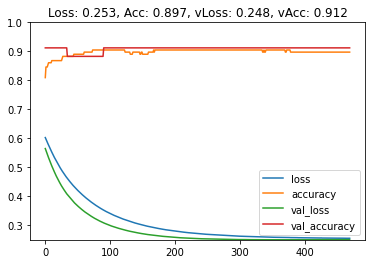

In [220]:

for r in results:
    print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(fire_import.models['pca']['X_test'], fire_import.y_test))
plot_loss_accuracy(results[0]['history'])
plt.show()

<Figure size 576x432 with 0 Axes>

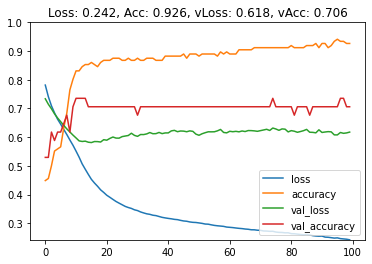

3/3 [==============================] - 0s 4ms/step - loss: 0.2692 - accuracy: 0.8784
[0.26920774579048157, 0.8783783912658691]


In [172]:
nn(
    X_train = fire_import.models['ica']['X_train'],
    y_train = fire_import.y_train,
    X_test = fire_import.models['ica']['X_test'],
    y_test = fire_import.y_test
)

<Figure size 576x432 with 0 Axes>

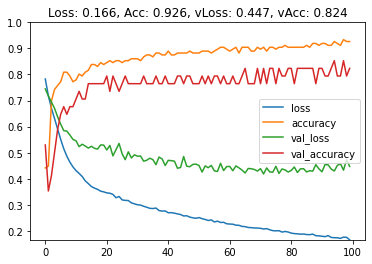

3/3 [==============================] - 0s 3ms/step - loss: 0.2526 - accuracy: 0.9054
[0.25259679555892944, 0.9054054021835327]


In [174]:
nn(
    X_train = fire_import.models['rp']['X_train'],
    y_train = fire_import.y_train,
    X_test = fire_import.models['rp']['X_test'],
    y_test = fire_import.y_test
)

<Figure size 576x432 with 0 Axes>

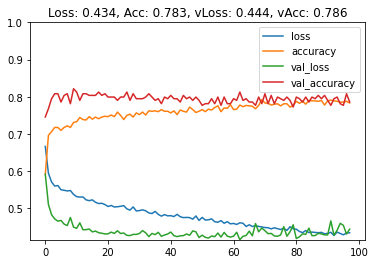

0.55625


array([1., 0.])

In [341]:
plot_loss_accuracy(wine2_results_raw[0]['history'])
plt.show()
print(len(wine2.y_test[wine2.y_test['good']==1]) / len(wine2.y_test))
wine2.y_train['good'].unique()